In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your dataset directory
dataset_dir = '/content/drive/MyDrive/Dataset'

# The paths for the training and validation directories
train_dir = '/content/working/training'
val_dir = '/content/working/validation'

# The categories
categories = ['anggur','apel','ayam-goreng','ayam-kampung','daging','nasi','pasta','pisang','roti','sayur','tahu','telur','tempe']

# Split ratio for validation
val_split_ratio = 0.2

# Create the training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for category in categories:
    # Create category-specific subdirectories in both the training and validation directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    # Get the full path for the current category
    category_path = os.path.join(dataset_dir, category)

    # Check if the category path exists
    if not os.path.exists(category_path):
        print(f"Category path does not exist: {category_path}")
        continue

    # List all files in the category directory
    all_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    # Split the files into training and validation sets
    train_files, val_files = train_test_split(all_files, test_size=val_split_ratio)

    # Copy the training files to the training directory
    for file_name in train_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(train_dir, category, file_name))

    # Copy the validation files to the validation directory
    for file_name in val_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(val_dir, category, file_name))


In [5]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
# Define paths
base_dir = '/content/working/'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')

In [7]:
# Define image dimensions
img_width, img_height = 224, 224
batch_size = 32

In [8]:
# Data augmentation configuration for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1445 images belonging to 13 classes.
Found 368 images belonging to 13 classes.


In [9]:
# Load MobileNetV2 as base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model


9406464/9406464 [==============================] - 1s 0us/step


In [10]:
# Define the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(13, activation='softmax')  # Final output layer with 2 classes
])

In [11]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [17]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.91):
            print('\nReached 98% accuracy for both training and validation. Stopping training.')
            self.model.stop_training = True

callback = AccuracyThresholdCallback()

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1000,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback]
)


Epoch 1/1000
45/45 [==============================] - 109s 2s/step - loss: 0.0676 - accuracy: 0.9781 - val_loss: 0.4064 - val_accuracy: 0.8864
Epoch 2/1000
45/45 [==============================] - 102s 2s/step - loss: 0.0623 - accuracy: 0.9809 - val_loss: 0.3563 - val_accuracy: 0.8949
Epoch 3/1000
45/45 [==============================] - 101s 2s/step - loss: 0.0669 - accuracy: 0.9788 - val_loss: 0.3573 - val_accuracy: 0.9034
Epoch 4/1000
45/45 [==============================] - 99s 2s/step - loss: 0.0859 - accuracy: 0.9703 - val_loss: 0.3583 - val_accuracy: 0.9034
Epoch 5/1000
45/45 [==============================] - 103s 2s/step - loss: 0.0604 - accuracy: 0.9795 - val_loss: 0.3783 - val_accuracy: 0.8977
Epoch 6/1000
45/45 [==============================] - 104s 2s/step - loss: 0.0625 - accuracy: 0.9781 - val_loss: 0.3984 - val_accuracy: 0.9062
Epoch 7/1000
45/45 [==============================] - 105s 2s/step - loss: 0.0637 - accuracy: 0.9788 - val_loss: 0.4233 - val_accuracy: 0.9034


In [19]:
# Save the model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                1

In [25]:
class_indices = train_generator.class_indices
print(class_indices)

{'anggur': 0, 'apel': 1, 'ayam-goreng': 2, 'ayam-kampung': 3, 'daging': 4, 'nasi': 5, 'pasta': 6, 'pisang': 7, 'roti': 8, 'sayur': 9, 'tahu': 10, 'telur': 11, 'tempe': 12}


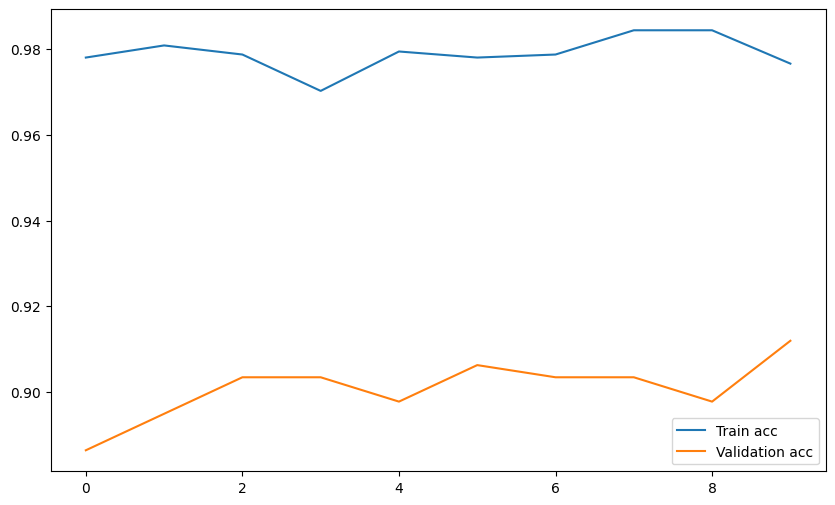

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

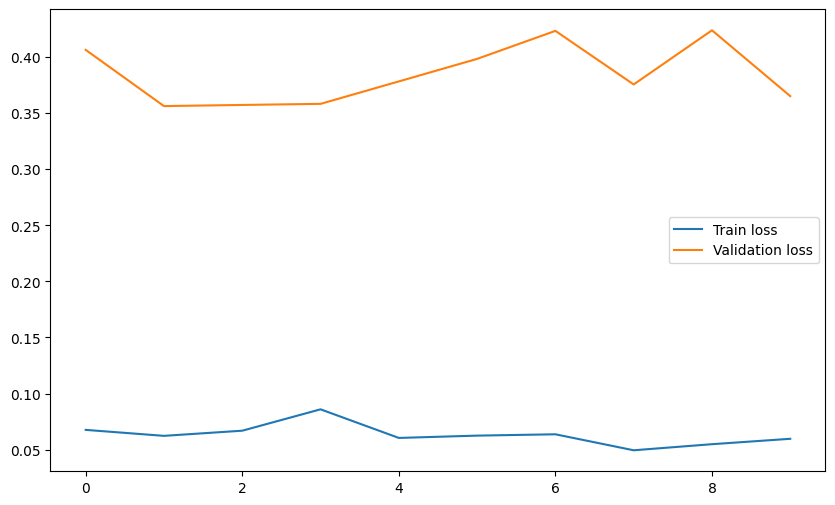

In [23]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


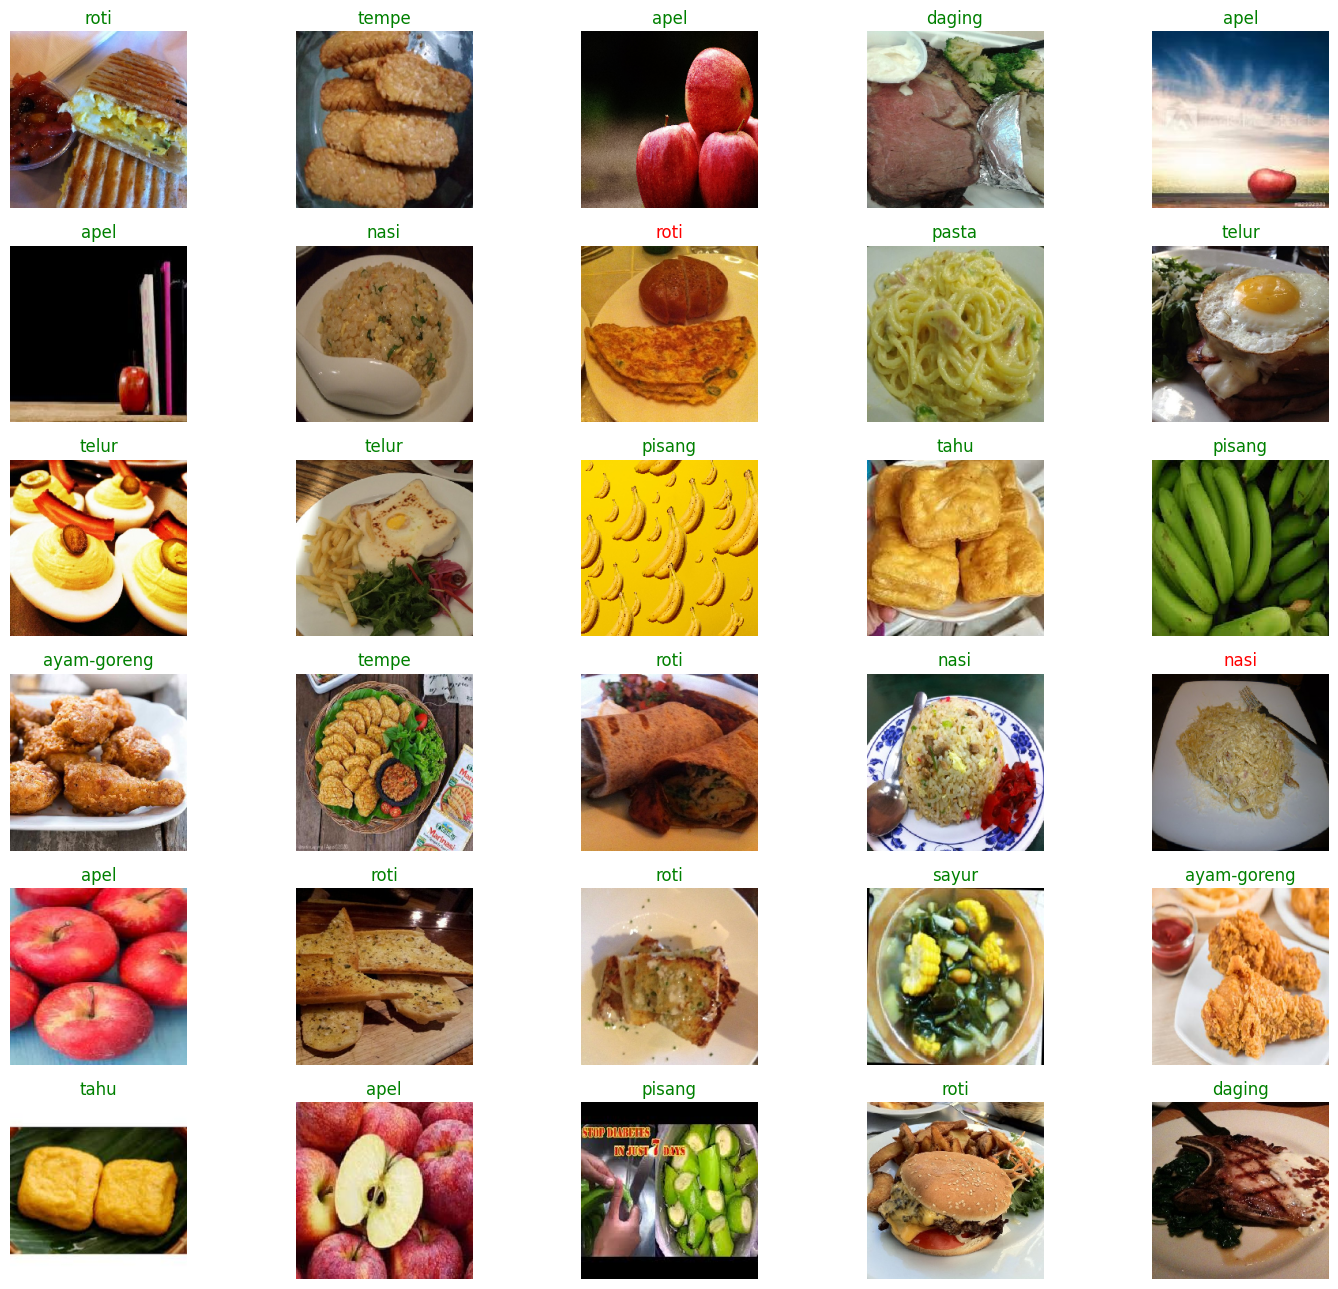

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/content/model.h5')

# Assuming validation_generator is already set up and is part of the code that was provided
# Make sure to use the correct directory for the validation data
# validation_generator = ...

# Get a batch of images from the validation generator
img, labels = next(validation_generator)

# Define the class indices (mapping) as obtained previously
# class_indices = {'Bread': 0, 'Egg': 1, 'Meat': 2, 'Noodles-Pasta': 3, 'Rice': 4, 'apple fruit': 5, 'banana fruit': 6, 'cherry fruit': 7, 'chickoo fruit': 8, 'grapes fruit': 9, 'sayur': 10, 'tahu': 11, 'tempe': 12}

# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i])

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
